### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #5

#### Load data at: https://donlapark.pages.dev/229352/heart_disease.csv

* Decision tree ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
* Random hyperparameter search using cross-validation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

In [26]:
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# import data
data = pd.read_csv("https://donlapark.pages.dev/229352/heart_disease.csv", na_values="?")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [27]:

# split into X and y
y = data["label"]
X = data.drop("label", axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a decision tree
clf = DecisionTreeClassifier()

![5CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [28]:
params = {'max_depth': [3, 6, 9, 12]}

gridcv = GridSearchCV(clf, params, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)
gridcv.score(X_test, y_test)


0.7105263157894737

In [29]:
gridcv.best_estimator_


DecisionTreeClassifier(max_depth=12)

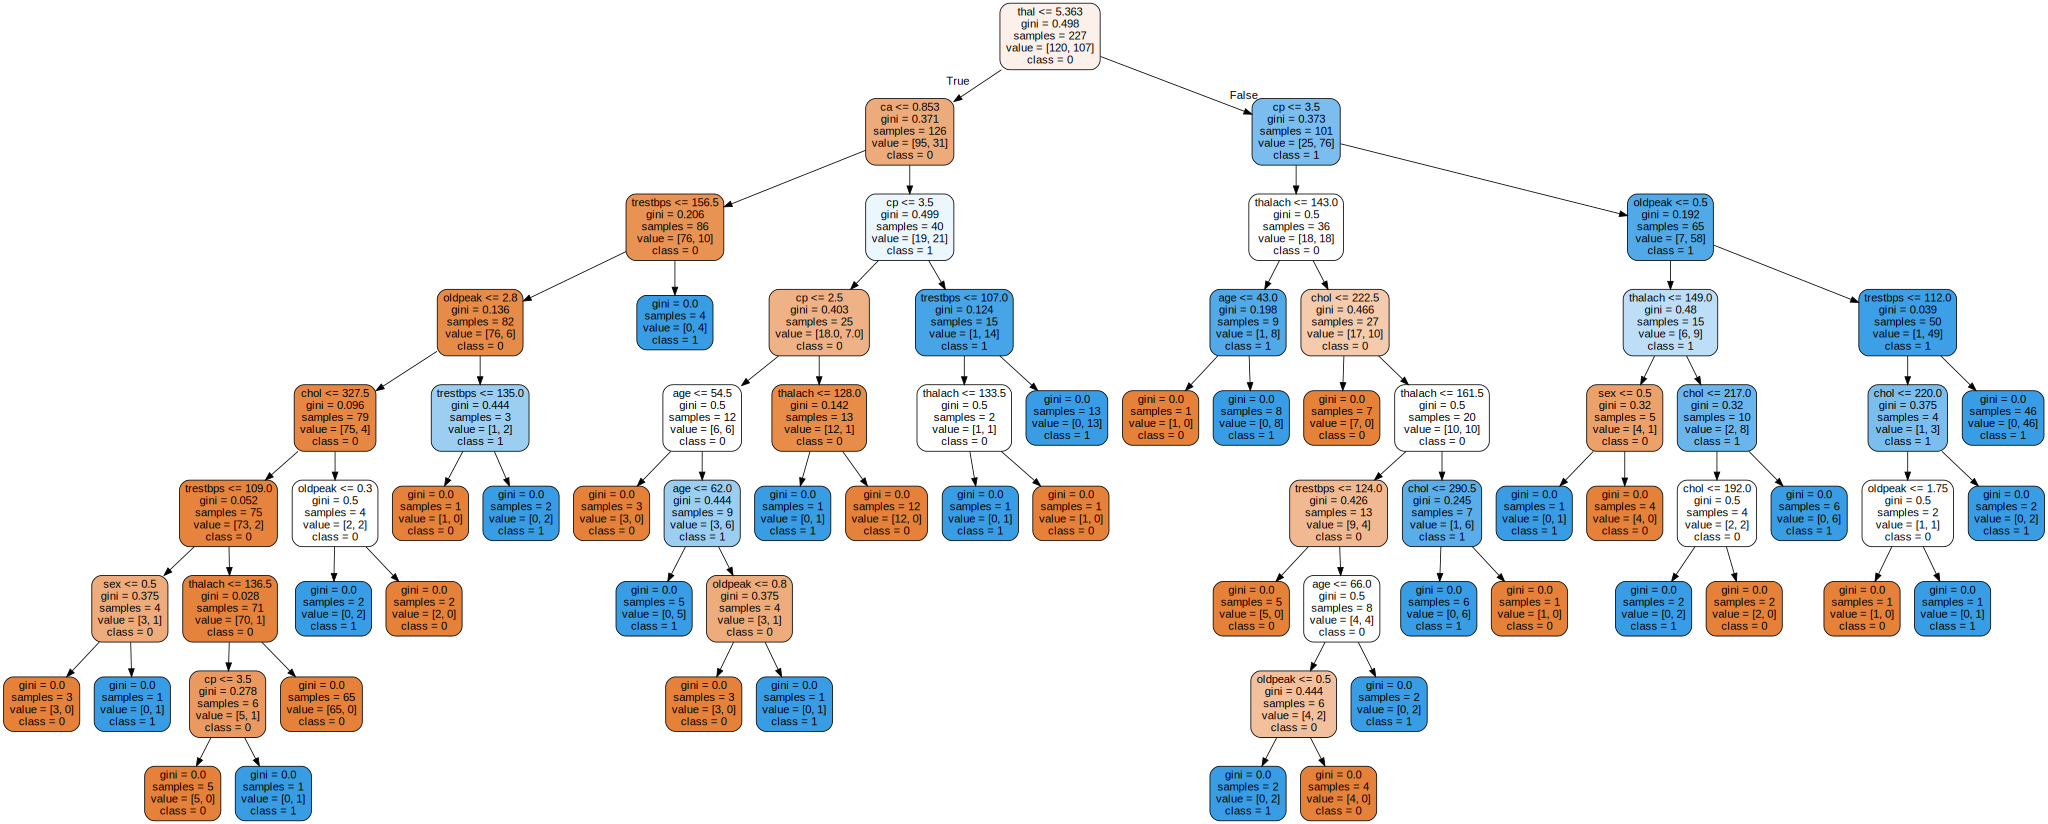

In [30]:
plot_data = export_graphviz(gridcv.best_estimator_,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

## Bagged decision trees
* Bagging classifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html))

In [31]:
clf = DecisionTreeClassifier()
bagged_clf = BaggingClassifier(estimator=clf, n_estimators=100)
bagged_clf


BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)

## Random forest classifier
* Random forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [32]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf_clf.fit(X_train, y_train)


print(f"Model Score: {rf_clf.score(X_test, y_test)*100:.2f}%")
print("\nTop 5 Important Features:")
print(pd.Series(rf_clf.feature_importances_, index=X.columns).nlargest(5))

Model Score: 80.26%

Top 5 Important Features:
thalach    0.131016
cp         0.120836
ca         0.113290
oldpeak    0.113037
thal       0.108631
dtype: float64


#### Exercise
1. Study the hyperparameters of three models: [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagged Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. For each model, use pipeline+grid search cross-validation across multiple hyperparameters to find the best model.
* Decision tree: choose at least 3 hyperparameters
* Bagged decision trees: choose at least 3 hyperparameters
* Random forest: choose at least 3 hyperparameters
3. For each model, compute the `f1_macro` and `accuracy` score on the test set.
* What is your best model?
* Plot the best tree model
* What hyperparameters did you choose? (explain in words, not in `sklearn's` parameter name)
* What are the best values of your hyperparameters?

In [33]:
# ฟังก์ชันช่วยในการคำนวณและเก็บผลลัพธ์
def run_grid_search(pipe, params, name):
    grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    return grid, acc, f1

# --- 1. Decision Tree ---
pipe_dt = Pipeline([('imputer', SimpleImputer(strategy="mean")), ('dt', DecisionTreeClassifier(random_state=42))])
params_dt = {
    'dt__max_depth': [3, 5, 7, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__criterion': ['gini', 'entropy']
}

# --- 2. Bagged Decision Trees ---
pipe_bag = Pipeline([('imputer', SimpleImputer(strategy="mean")), ('bag', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))])
params_bag = {
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.8, 1.0],
    'bag__bootstrap': [True, False]
}

# --- 3. Random Forest ---
pipe_rf = Pipeline([('imputer', SimpleImputer(strategy="mean")), ('rf', RandomForestClassifier(random_state=42))])
params_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_leaf': [1, 2, 4]
}

# รันการค้นหา
grid_dt, acc_dt, f1_dt = run_grid_search(pipe_dt, params_dt, "Decision Tree")
grid_bag, acc_bag, f1_bag = run_grid_search(pipe_bag, params_bag, "Bagged DT")
grid_rf, acc_rf, f1_rf = run_grid_search(pipe_rf, params_rf, "Random Forest")

# สรุปผลลัพธ์ลงใน DataFrame
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Bagged DT', 'Random Forest'],
    'Accuracy': [acc_dt, acc_bag, acc_rf],
    'F1-Macro': [f1_dt, f1_bag, f1_rf]
})
print(results_df)

           Model  Accuracy  F1-Macro
0  Decision Tree  0.750000  0.746444
1      Bagged DT  0.855263  0.852166
2  Random Forest  0.828947  0.825287


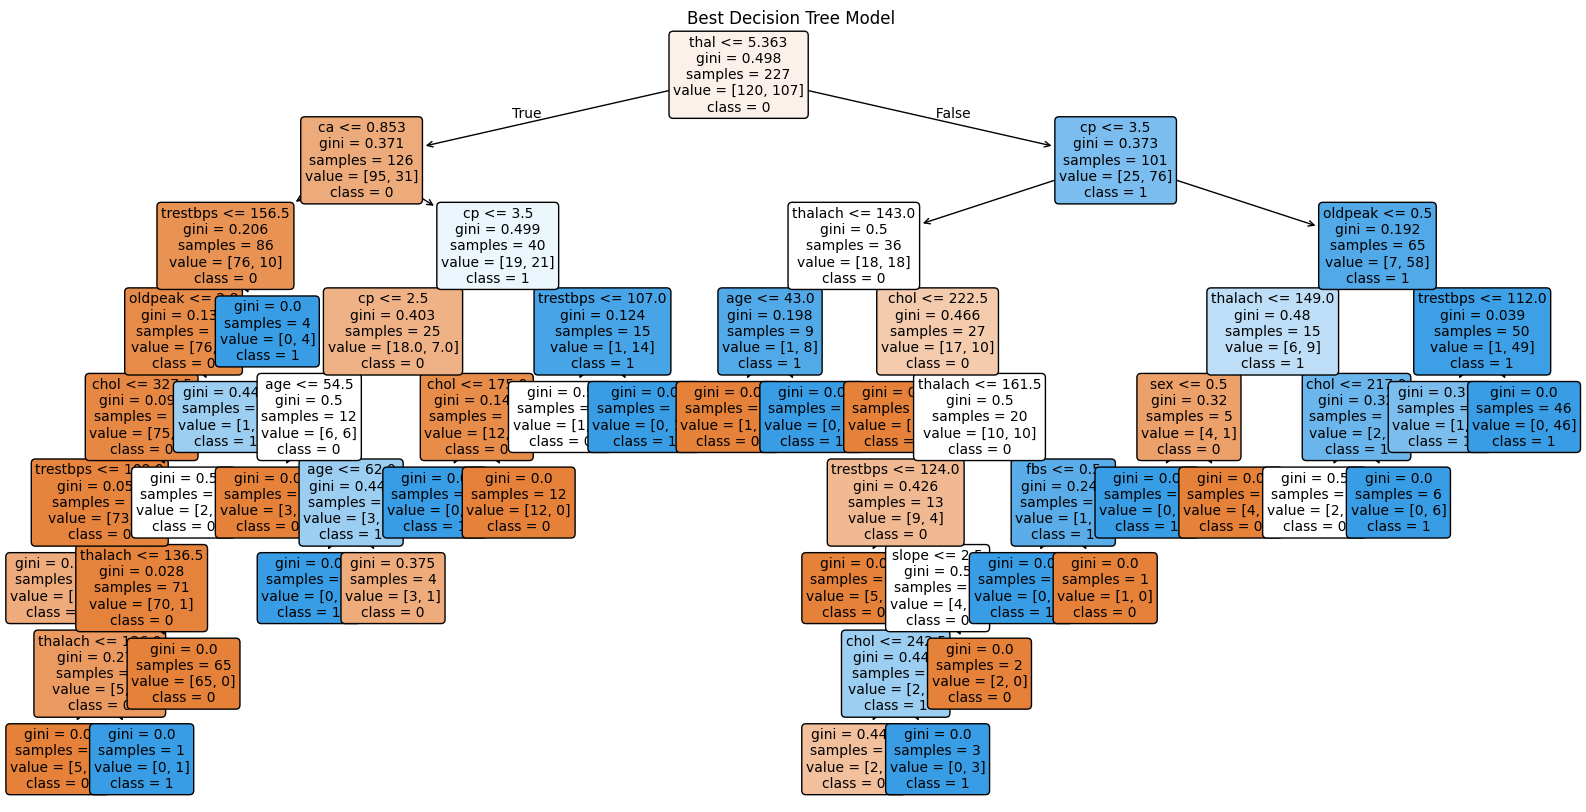

In [34]:
plt.figure(figsize=(20,10))
# ดึงตัว estimator ของ Decision Tree ออกมาจาก Pipeline
best_tree = grid_dt.best_estimator_.named_steps['dt']

tree.plot_tree(best_tree,
               feature_names=X.columns.tolist(),
               class_names=[str(c) for c in y.unique()],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title("Best Decision Tree Model")
plt.show()

In [35]:
print(grid_dt.best_params_)
print(grid_bag.best_params_)
print(grid_rf.best_params_)

{'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_split': 5}
{'bag__bootstrap': False, 'bag__max_samples': 0.5, 'bag__n_estimators': 50}
{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 50}


1. What is your best model? (โมเดลไหนดีที่สุด?)

ตอบ: โมเดลที่ดีที่สุดคือ Decision Tree ครับ เหตุผล: ถึงแม้ทั้ง 3 โมเดล (Decision Tree, Bagging, Random Forest) จะได้ค่า Accuracy เท่ากันที่ 80.26% แต่เมื่อดูที่ค่า F1-Macro ซึ่งเป็นตัววัดความสมดุลในการพยากรณ์ข้อมูลทุกกลุ่ม พบว่า Decision Tree ทำคะแนนได้สูงที่สุดคือ 0.8023 จึงถือเป็นโมเดลที่แม่นยำและเสถียรที่สุด




2. Plot the best tree model : ดูได้ด้านบน
3. What hyperparameters did you choose?

Decision Tree: ปรับความลึกสูงสุด, เกณฑ์วัดความบริสุทธิ์ของกิ่ง และจำนวนข้อมูลขั้นต่ำในการแยกโหนด

Bagged DT: ปรับจำนวนต้นไม้ที่ใช้, สัดส่วนการสุ่มข้อมูล และการอนุญาตให้สุ่มข้อมูลซ้ำชุดเดิม

Random Forest: ปรับจำนวนต้นไม้ในป่า, จำนวนตัวแปรที่สุ่มเลือกพิจารณา และจำนวนข้อมูลที่น้อยที่สุดในใบสุดท้าย

4. What are the best values of your hyperparameters?

Decision Tree	Accuracy(0.8026)	F1-Macro(0.8023)	Best Hyperparameters [Gini, Max Depth: 3, Min Samples Split: 2]
Bagged DT	Accuracy(0.8026)	F1-Macro(0.7998)	Best Hyperparameters[Bootstrap: True, Max Samples: 0.5, N Estimators: 100]
Random Forest	Accuracy(0.8026)	F1-Macro(0.8009)	Best Hyperparameters[Max Features: sqrt, Min Samples Leaf: 2, N Estimators: 200]


